# Setup

In [1]:
# check GPU
!nvidia-smi

Fri Dec 30 21:38:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# pulls repo to colab
!git clone https://github.com/char-tan/mode_connectivity.git

# checkout specific branch if needed
!cd mode_connectivity; git checkout main

Cloning into 'mode_connectivity'...
remote: Enumerating objects: 402, done.
remote: Counting objects: 100% (180/180), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 402 (delta 106), reused 125 (delta 85), pack-reused 222
Receiving objects: 100% (402/402), 7.12 MiB | 24.45 MiB/s, done.
Resolving deltas: 100% (225/225), done.
Already on 'main'
Your branch is up to date with 'origin/main'.


In [4]:
# allows you to change the .py files and have the imports updated
%load_ext autoreload
%autoreload 2

In [19]:
import sys, os
SCRIPT_DIR = os.path.dirname(os.path.abspath('.'))
sys.path.append(os.path.dirname(SCRIPT_DIR))

from mode_connectivity.training import *
from mode_connectivity.lmc import *
from mode_connectivity.training_config import *

from mode_connectivity.models.mlp import MLP
from mode_connectivity.models.vgg import VGG
from mode_connectivity.models.resnet import ResNet

from mode_connectivity.utils import weight_matching, data, training_utils, plot, utils

import torch
from torchvision import transforms
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Training

In [3]:
training_config = MLP_MNIST_DEFAULT
training_config.epochs = 5
training_config.seed = 7

# train model a
model_a = train_model(*setup_train(training_config), verbose = 1)
torch.save(model_a.state_dict(), 'model_a.pt')

# change seed to get different model
training_config.seed = 42

# train model b
model_b = train_model(*setup_train(training_config), verbose = 1)
torch.save(model_b.state_dict(), 'model_b.pt')  

Train Epoch: 1, Train Accuracy: (90%) 
Average loss: 0.1298, Accuracy: (96%)
Train Epoch: 2, Train Accuracy: (97%) 
Average loss: 0.0949, Accuracy: (97%)
Train Epoch: 3, Train Accuracy: (98%) 
Average loss: 0.0719, Accuracy: (98%)
Train Epoch: 4, Train Accuracy: (99%) 
Average loss: 0.0850, Accuracy: (97%)
Train Epoch: 5, Train Accuracy: (99%) 
Average loss: 0.0756, Accuracy: (98%)
Train Epoch: 1, Train Accuracy: (90%) 
Average loss: 0.1396, Accuracy: (96%)
Train Epoch: 2, Train Accuracy: (97%) 
Average loss: 0.0961, Accuracy: (97%)
Train Epoch: 3, Train Accuracy: (98%) 
Average loss: 0.0796, Accuracy: (98%)
Train Epoch: 4, Train Accuracy: (98%) 
Average loss: 0.0721, Accuracy: (98%)
Train Epoch: 5, Train Accuracy: (99%) 
Average loss: 0.0849, Accuracy: (98%)


# LMC

In [13]:
n_points = 20
(
    permuted_params,
    train_acc_naive,
    test_acc_naive,
    train_acc_perm,
    test_acc_perm,
) = linear_mode_connect(
    MLP, "model_a.pt", "model_b.pt", "mnist", n_points=n_points, verbose=1
)



performing naive interpolation
point 20/20. 
permuting model

performing permuted interpolation


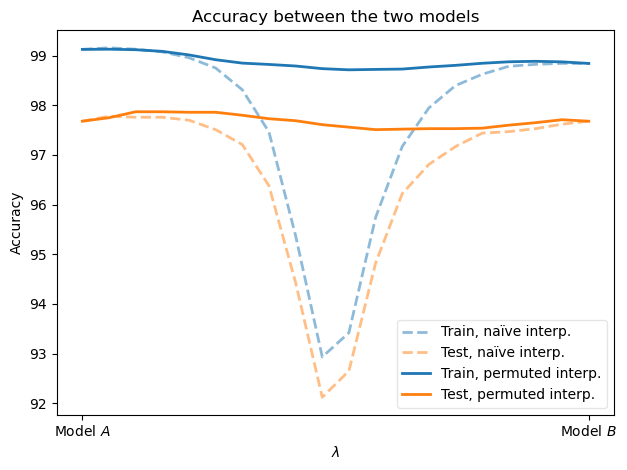

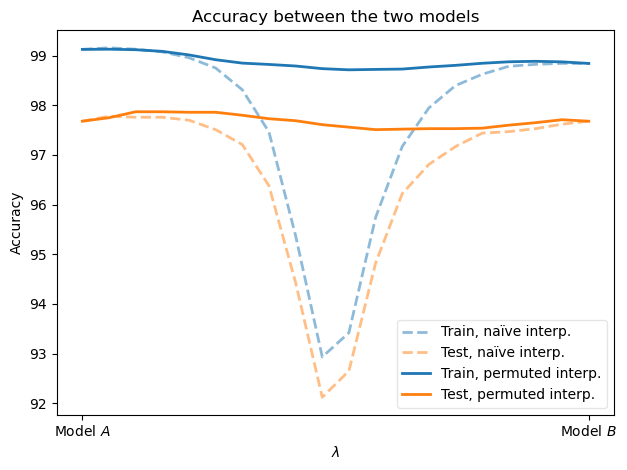

In [53]:
# First we do the basic linear interpolation plot
lambdas = torch.linspace(0, 1, steps=n_points)
plot.plot_interp_metric("accuracy", lambdas, train_acc_naive, test_acc_naive, train_acc_perm, test_acc_perm)

In [50]:
# Now we generate the contour plot
a_params = torch.load("model_a.pt") 
b_params = torch.load("model_b.pt") 
v1, v2, v3 = (
    utils.state_dict_to_numpy_array(p) for p in [a_params, b_params, permuted_params]
)
contour_plane = utils.generate_orthogonal_basis(v1, v2, v3)
train_loader, test_loader = data.get_data_loaders(
    dataset="mnist", train_kwargs={"batch_size":512}, test_kwargs={"batch_size":512}
)
device, _ = get_device()
(
    t1s,
    t2s,
    test_acc_grid,
    test_loss_grid,
    train_acc_grid,
    train_loss_grid,
) = utils.generate_loss_landscape_contour(
    model_a, device, train_loader, test_loader, contour_plane, granularity=10
)


11it [05:40, 30.97s/it]


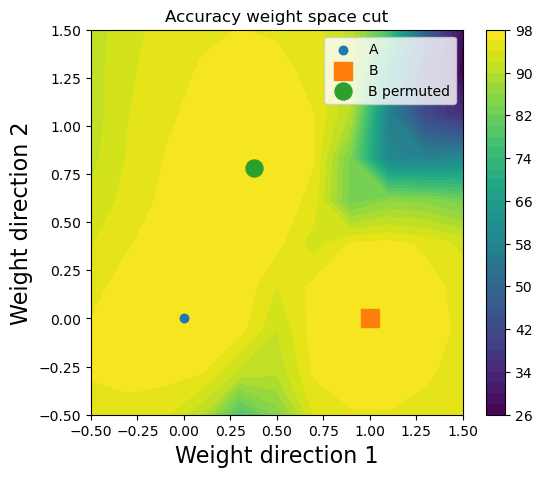

In [51]:
plot.plot_metric_contour(
    "accuracy",
    t1s,
    t2s,
    test_acc_grid,
    model_vectors_dict={
        "A": utils.projection(v1, contour_plane),
        "B": utils.projection(v2, contour_plane),
        "B permuted": utils.projection(v3, contour_plane),
    },
)
